In [284]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import BatchNorm, GCNConv, LayerNorm
from torch_geometric.utils import to_networkx

# Check if gpu available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


# Data loading.

In [285]:
# Load in social spambots 1, 2 and 3
bots1 = pd.read_csv('data/datasets_full/social_spambots_1/tweets.csv', lineterminator='\n', encoding='latin1', low_memory = False)
bots2 = pd.read_csv('data/datasets_full/social_spambots_2/tweets.csv', lineterminator='\n', encoding='latin1', low_memory = False)
bots3 = pd.read_csv('data/datasets_full/social_spambots_3/tweets.csv', lineterminator='\n', encoding='latin1', low_memory = False)

fake_followers = pd.read_csv('data/datasets_full/fake_followers/tweets.csv', lineterminator='\n', encoding='latin1', low_memory = False)
traditional_spambots1 = pd.read_csv('data/datasets_full/traditional_spambots_1/tweets.csv', lineterminator='\n', encoding='latin1', low_memory = False)

genuine = pd.read_csv('data/datasets_full/genuine_accounts/my_table.csv', lineterminator='\n', encoding='latin1', delimiter='\t', low_memory = False)

In [286]:
# Count total rows across all datasets
total_rows = bots1.shape[0] + bots2.shape[0] + bots3.shape[0] + fake_followers.shape[0] + traditional_spambots1.shape[0] + genuine.shape[0]
total_rows

12175775

# Data preprocessing.

In [287]:
# Add a bot column to the dataframes. Bots = 1 for bots1, bots2, bots3, fake_followers, traditional_spambots1 and 0 for genuine.
bots1['bot'] = 1
bots2['bot'] = 1
bots3['bot'] = 1

fake_followers['bot'] = 1
traditional_spambots1['bot'] = 1

genuine['bot'] = 0

In [288]:
# Clean the dataframes. Keep only the relevant features.
keep = ['text', 'user_id', 'in_reply_to_user_id', 'retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions', 'bot']

bots1_clean = bots1[keep]
bots2_clean = bots2[keep]
bots3_clean = bots3[keep]

fake_followers_clean = fake_followers[keep]
traditional_spambots1_clean = traditional_spambots1[keep]

genuine_clean = genuine[keep]

In [289]:
# Concatenate the dataframes.

# Bots 1, 2, 3 and genuine.
# df = pd.concat([bots1_clean, bots2_clean, bots3_clean, genuine_clean], ignore_index=True)

# Bots 1, 2, 3, fake followers, traditional spambots 1 and genuine.
df = pd.concat([bots1_clean, bots2_clean, bots3_clean, fake_followers_clean, traditional_spambots1_clean, genuine_clean], ignore_index=True)

# Randomly shuffle the dataframe.
df = df.sample(frac=1).reset_index(drop=True)

print("Dataframe shape:", df.shape)

Dataframe shape: (12175775, 10)


In [290]:
# Drop rows with NaN values.
rows_before = df.shape[0]

df = df.dropna()
df = df.reset_index(drop=True)

rows_after = df.shape[0]
print(f'Dropped {rows_before - rows_after:,} rows')
print(f'Rows remaining: {rows_after:,}')

Dropped 58,625 rows
Rows remaining: 12,117,150


In [291]:
# Convert user_id, in_reply_to_user_id, favorite_count and num_mentions to integers.
df['user_id'] = df['user_id'].astype(int)
df['in_reply_to_user_id'] = df['in_reply_to_user_id'].astype(int)
df['favorite_count'] = df['favorite_count'].astype(int)
df['num_mentions'] = df['num_mentions'].astype(int)

In [292]:
# Count how many rows are bots and percentage of bots.
print('Number of bots:', df[df['bot'] == 1].shape[0])
print('Number of genuine:', df[df['bot'] == 0].shape[0])
print("Percent bots: {:.2f}%".format(df[df['bot'] == 1].shape[0] / df.shape[0] * 100))

Number of bots: 3797819
Number of genuine: 8319331
Percent bots: 31.34%


# Graph model.

### Helper functions.

In [295]:
def agg_user_id(df, aggregator = 'mean'):
    # Aggregate user_id
    df_copy = df.groupby('user_id').agg({
        'user_id': 'first',
        'in_reply_to_user_id': lambda x: list(set(x)),
        'retweet_count': aggregator,
        'reply_count': aggregator,
        'favorite_count': aggregator,
        'num_hashtags': aggregator,
        'num_urls': aggregator,
        'num_mentions': aggregator,
        'bot': 'first'
    }).reset_index(drop=True)
    # Remove in_reply_to_user_ids that are not in the user_id column or are zero
    user_ids = set(df['user_id'].unique())
    df_copy['in_reply_to_user_id'] = df_copy['in_reply_to_user_id'].apply(lambda x: [i for i in x if i in user_ids and i != 0])

    df_copy.reset_index(drop=True, inplace=True)
    return df_copy

def generate_user_id_mappping(df):
    user_ids = df['user_id'].tolist()
    in_reply_to_user_ids = [id for row in df['in_reply_to_user_id'] for id in row]
    all_user_ids = set(user_ids + in_reply_to_user_ids)
    user_id_mapping = {id: i for i, id in enumerate(all_user_ids)}
    return user_id_mapping

def stratify_data(data, test_size=0.2, random_state=42):
    # Ensure labels are numpy arrays
    labels = data.y.numpy() if isinstance(data.y, torch.Tensor) else data.y
    # Perform stratified split
    train_idx, test_idx = train_test_split(np.arange(len(labels)), test_size=test_size, stratify=labels, random_state=random_state)
    
    # Create boolean train and test masks
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_idx] = True
    test_mask[test_idx] = True
    
    return train_mask, test_mask

def construct_features_labels_edges(df, mapping, features, labels):
    # Features
    scaler = StandardScaler()
    features = torch.tensor(scaler.fit_transform(df[features]), dtype=torch.float)

    # Labels
    labels = torch.tensor(df[labels].values, dtype=torch.float)

    # Edges
    edges = []
    for i, row in df.iterrows():
        for j in row['in_reply_to_user_id']:
            edges.append((mapping[row['user_id']], mapping[j]))

    edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    return features, edges, labels

def create_and_print_graph(data, top_n, seed):
    G = to_networkx(data, to_undirected=True, node_attrs=['y'])
    
    # Compute the degree centrality and sort nodes
    degree_centrality = nx.degree_centrality(G)
    sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    
    # Get the top n nodes
    top_n_nodes = [node for node, _ in sorted_degree_centrality[:top_n]]
    
    # Create a subgraph with the top n nodes
    subgraph = G.subgraph(top_n_nodes)
    pos = nx.spring_layout(subgraph, seed=seed)
    
    # Create a color map based on the 'y' attribute
    color_map = []
    for node in subgraph:
        if subgraph.nodes[node]['y'] == 0:
            color_map.append('green')
        else:
            color_map.append('red')
    
    # Draw the subgraph with color coding
    plt.figure(figsize=(30, 20))
    
    # Add legend
    red_patch = mpatches.Patch(color='red', label='Bot')
    green_patch = mpatches.Patch(color='green', label='Genuine')
    plt.legend(handles=[red_patch, green_patch], prop={'size': 20})
    
    nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color=color_map)
    nx.draw_networkx_edges(subgraph, pos, width=1)
    plt.axis('off')
    plt.show()

### Generate grouping.

In [296]:
# Group by user_id
user_id_group_df = agg_user_id(df, 'sum')

### Construct the graph features, edges, and labels.

In [298]:
node_features = ['retweet_count', 'reply_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions']
label = 'bot'

mapping = generate_user_id_mappping(user_id_group_df)
features, edges, labels = construct_features_labels_edges(user_id_group_df, mapping, node_features, label)

### Instantiate the graph.

In [299]:
data = Data(x=features, edge_index=edges, y=labels)
data

Data(x=[12508, 6], edge_index=[2, 5023], y=[12508])

In [300]:
train_mask, test_mask = stratify_data(data, test_size=0.2, random_state=42)

In [301]:
data.train_mask = train_mask
data.test_mask = test_mask
data

Data(x=[12508, 6], edge_index=[2, 5023], y=[12508], train_mask=[12508], test_mask=[12508])

In [337]:
class GCN_Baseline(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN_Baseline, self).__init__()
        self.conv1 = GCNConv(num_features, num_classes) # First GCN layer
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First layer
        x = self.conv1(x, edge_index)
        
        # Softmax
        x = F.log_softmax(x, dim=1)
        
        return x
    
    def ret_self(self):
        return self
    
    def train_model(self, data, train_mask, optimizer, criterion):
        self.train()
        optimizer.zero_grad()
        out = self(data)
        # accuracy
        pred = out.argmax(dim=1)
        correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
        acc = int(correct) / int(data.train_mask.sum())
        # loss
        loss = criterion(out[train_mask], data.y[train_mask].long())
        loss.backward()
        optimizer.step()
        return loss.item(), acc
    
    def test_model(self, data, test_mask, criterion, report_type='accuracy'):
        self.eval()
        with torch.no_grad():
            logits = self(data)
            pred = logits[test_mask].max(1)[1]
            
            loss = criterion(logits[test_mask], data.y[test_mask].long())
            
            if report_type == 'accuracy':
                # Return accuracy
                correct = pred.eq(data.y[test_mask].long()).sum().item()
                acc = correct / test_mask.sum().item()
                return loss.item(), acc
            
            if report_type == 'classification_report':
                # Return classification report
                return classification_report(data.y[test_mask].long().numpy(), pred.numpy())

In [338]:
model = GCN_Baseline(num_features=features.size(1), num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1000

# Set to 1 to print classification report, 0 to print accuracy
print_classification_report = 0

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    loss, accuracy = model.train_model(data, train_mask, optimizer, criterion)
    train_losses.append(loss)
    train_accuracies.append(accuracy)
    
    loss, accuracy = model.test_model(data, test_mask, criterion)
    test_losses.append(loss)
    test_accuracies.append(accuracy)
    if (epoch + 1) % 100 == 0:
        print(f'Epoch: {(epoch + 1):03d}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}')

Epoch: 100, Train Loss: 0.5545, Train Acc: 0.8256, Test Loss: 0.5964, Test Acc: 0.8265
Epoch: 200, Train Loss: 0.4356, Train Acc: 0.8543, Test Loss: 0.4733, Test Acc: 0.8521
Epoch: 300, Train Loss: 0.3758, Train Acc: 0.8642, Test Loss: 0.4097, Test Acc: 0.8625
Epoch: 400, Train Loss: 0.3402, Train Acc: 0.8679, Test Loss: 0.3712, Test Acc: 0.8653
Epoch: 500, Train Loss: 0.3172, Train Acc: 0.8987, Test Loss: 0.3461, Test Acc: 0.8973
Epoch: 600, Train Loss: 0.3012, Train Acc: 0.9000, Test Loss: 0.3281, Test Acc: 0.8981
Epoch: 700, Train Loss: 0.2896, Train Acc: 0.9017, Test Loss: 0.3146, Test Acc: 0.8993
Epoch: 800, Train Loss: 0.2808, Train Acc: 0.9026, Test Loss: 0.3038, Test Acc: 0.9017
Epoch: 900, Train Loss: 0.2739, Train Acc: 0.9045, Test Loss: 0.2951, Test Acc: 0.9025
Epoch: 1000, Train Loss: 0.2685, Train Acc: 0.9063, Test Loss: 0.2880, Test Acc: 0.9025


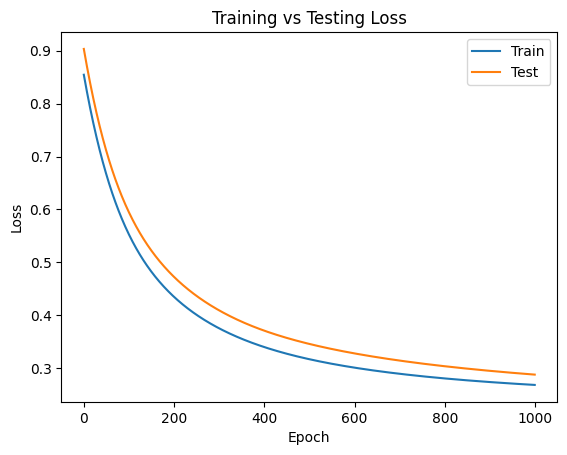

In [339]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Training vs Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

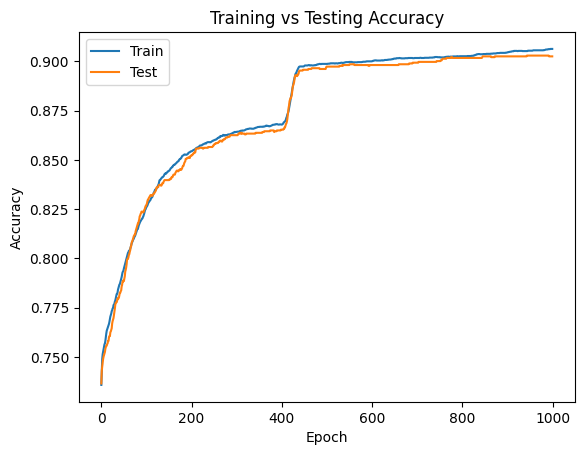

In [340]:
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [308]:
print(model.test_model(data, test_mask, criterion, report_type='classification_report'))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       679
           1       0.95      0.96      0.96      1823

    accuracy                           0.94      2502
   macro avg       0.93      0.92      0.92      2502
weighted avg       0.94      0.94      0.94      2502



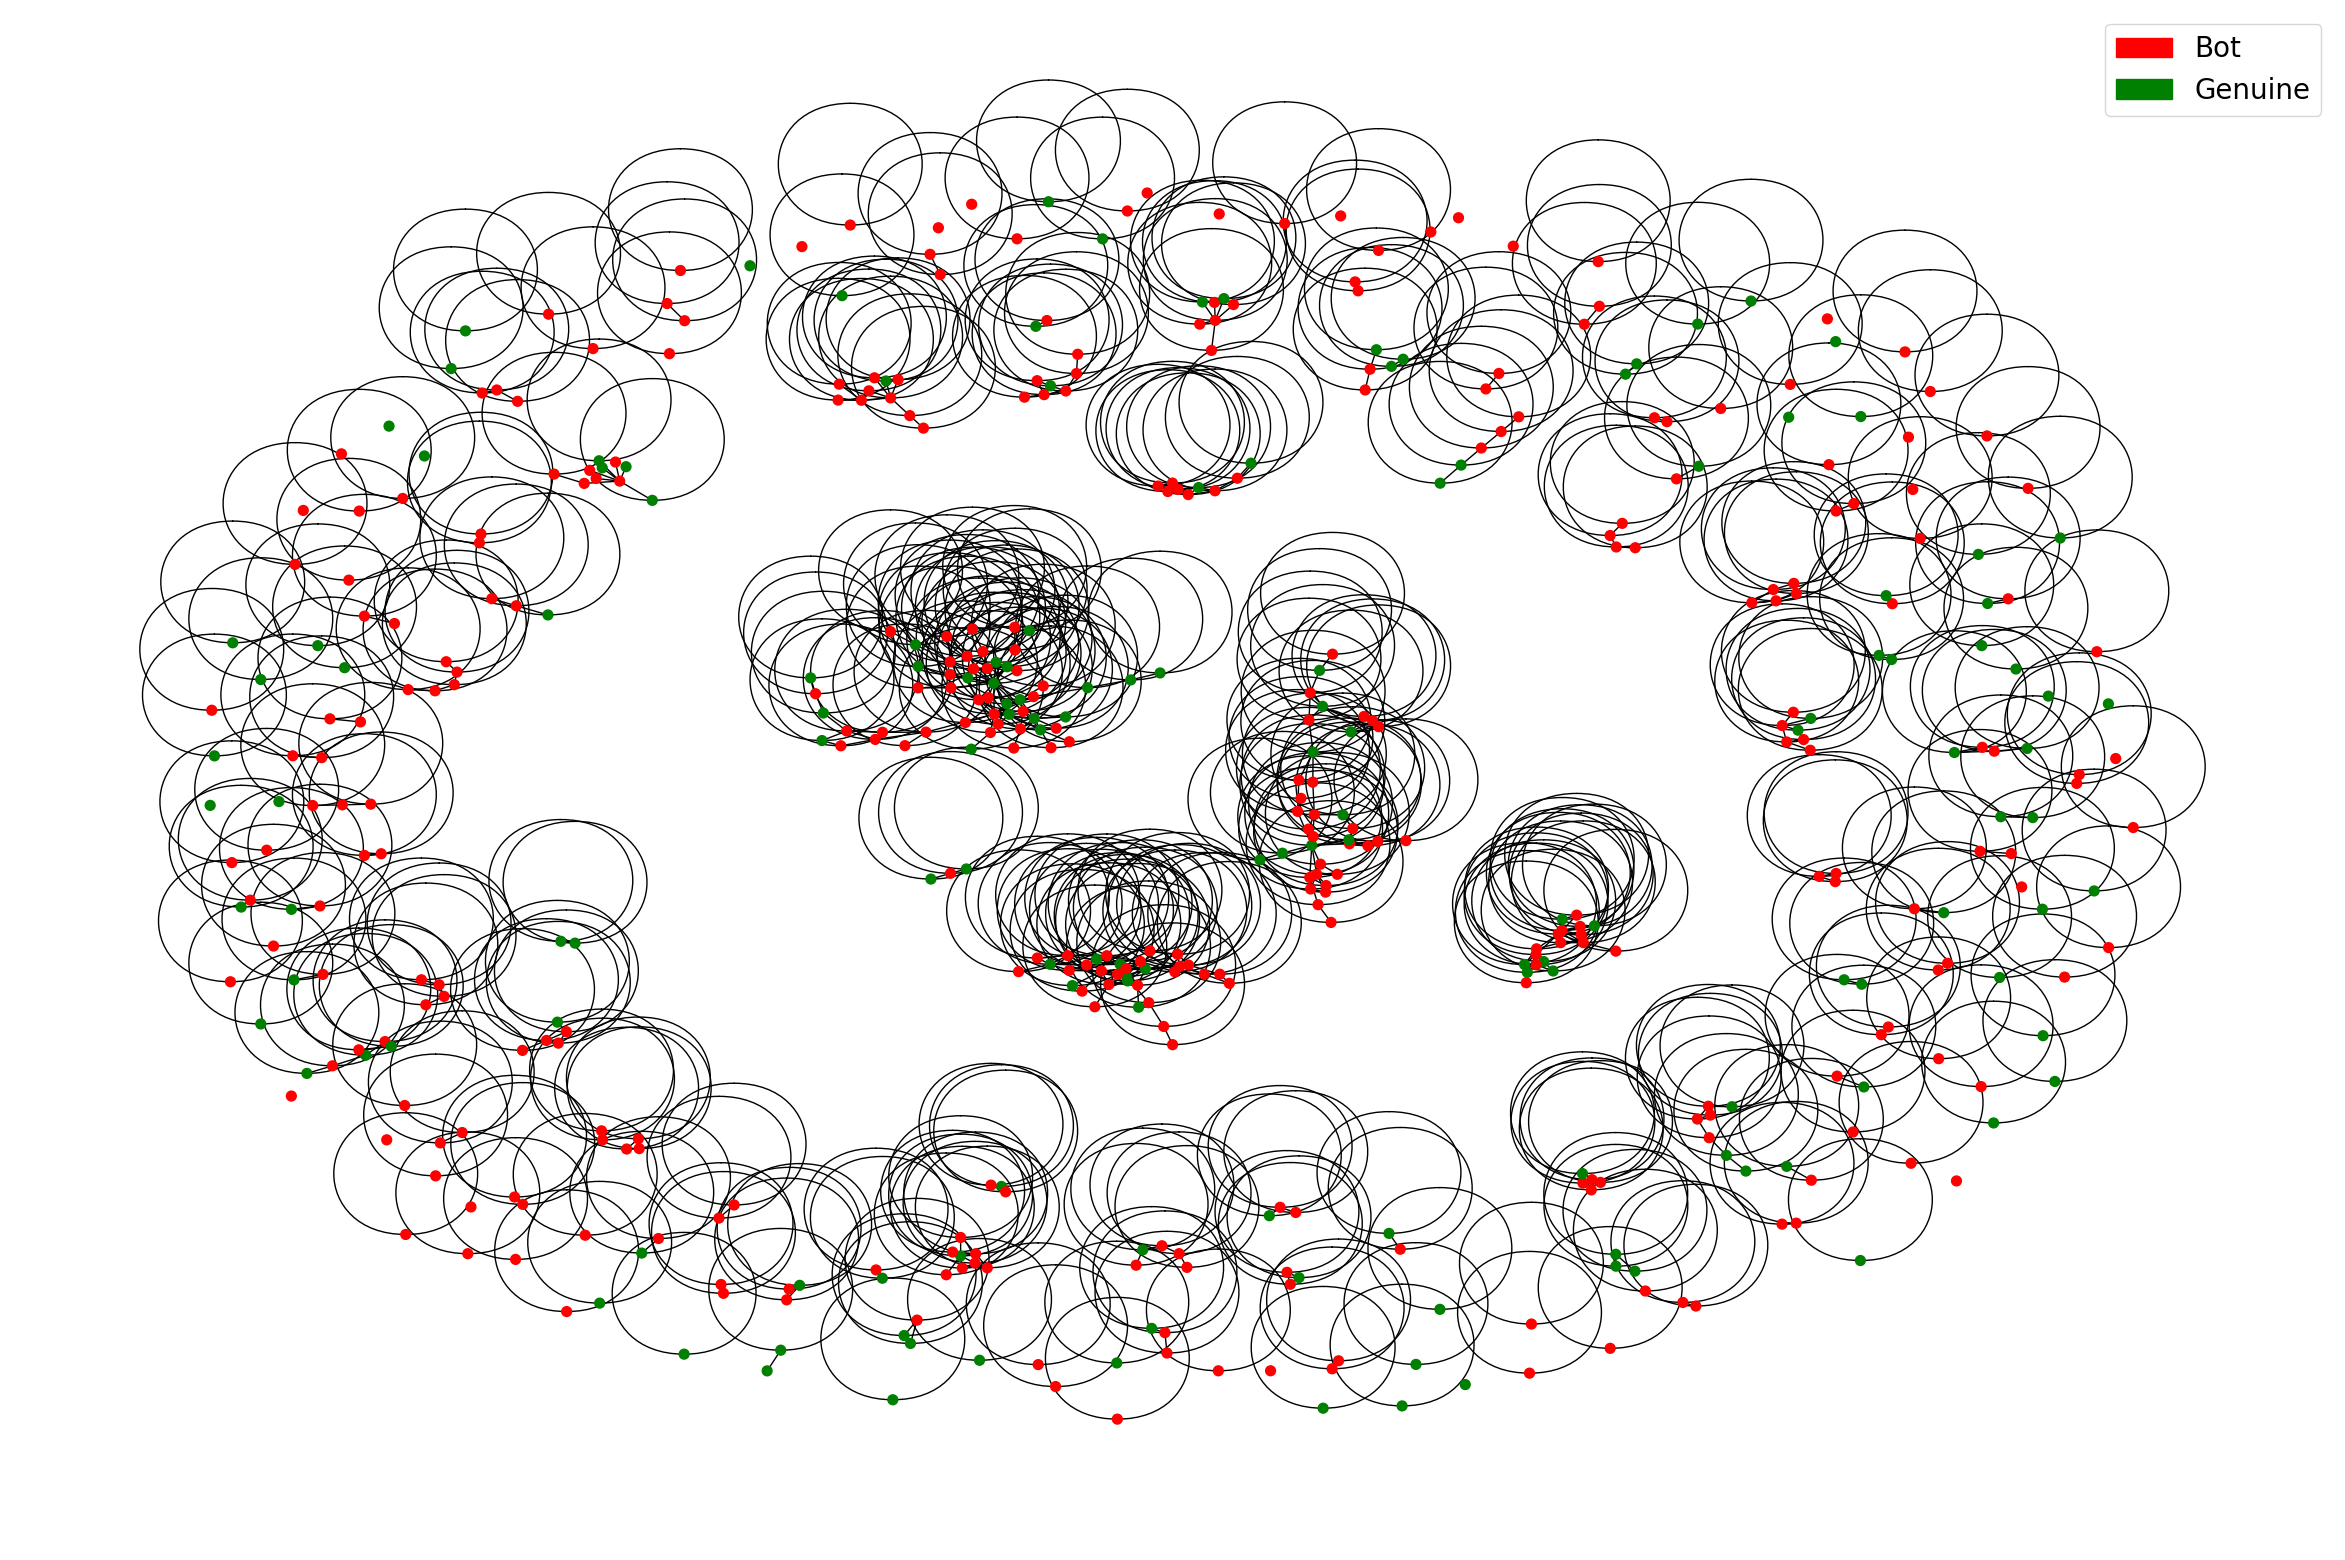

In [201]:
create_and_print_graph(data, top_n = 500, seed = 42)

In [342]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, LayerNorm

class GCN_Enhanced(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN_Enhanced, self).__init__()
        # Define GCN layers with increased depth and normalization
        self.conv1 = GCNConv(num_features, 64)  # First GCN layer
        self.norm1 = LayerNorm(64)
        self.conv2 = GCNConv(64, 32)            # Second GCN layer
        self.norm2 = LayerNorm(32)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.conv3 = GCNConv(32, 16)            # Third GCN layer
        self.norm3 = LayerNorm(16)
        self.conv4 = GCNConv(16, num_classes)   # Fourth GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer with normalization
        x1 = self.conv1(x, edge_index)
        x1 = F.relu(self.norm1(x1))

        # Second GCN layer with normalization
        x2 = self.conv2(x1, edge_index)
        x2 = F.relu(self.norm2(x2))
        x2 = self.dropout1(x2)
        
        # Third GCN layer with normalization
        x3 = self.conv3(x2, edge_index)
        x3 = F.relu(self.norm3(x3))

        # Fourth GCN layer with normalization
        x4 = self.conv4(x3, edge_index)

        # Softmax for classification
        x_final = F.softmax(x4, dim=1)
        
        return x_final

    def train_model(self, data, train_mask, optimizer, criterion):
        self.train()
        optimizer.zero_grad()
        out = self(data)
        # accuracy
        pred = out.argmax(dim=1)
        correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
        acc = int(correct) / int(data.train_mask.sum())
        # loss
        loss = criterion(out[train_mask], data.y[train_mask].long())
        loss.backward()
        optimizer.step()
        return loss.item(), acc
    
    def test_model(self, data, test_mask, criterion, report_type='accuracy'):
        self.eval()
        with torch.no_grad():
            logits = self(data)
            pred = logits[test_mask].max(1)[1]
            
            loss = criterion(logits[test_mask], data.y[test_mask].long())
            
            if report_type == 'accuracy':
                # Return accuracy
                correct = pred.eq(data.y[test_mask].long()).sum().item()
                acc = correct / test_mask.sum().item()
                return loss.item(), acc
            
            if report_type == 'classification_report':
                # Return classification report
                return classification_report(data.y[test_mask].long().numpy(), pred.numpy())

In [345]:
model = GCN_Enhanced(num_features=features.size(1), num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
epochs = 1500

# Set to 1 to print classification report, 0 to print accuracy
print_classification_report = 0

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    loss, accuracy = model.train_model(data, train_mask, optimizer, criterion)
    train_losses.append(loss)
    train_accuracies.append(accuracy)
    
    loss, accuracy = model.test_model(data, test_mask, criterion)
    test_losses.append(loss)
    test_accuracies.append(accuracy)
    if (epoch + 1) % 100 == 0:
        print(f'Epoch: {(epoch + 1):03d}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}')

In [332]:
print(model.test_model(data, test_mask, criterion, report_type='classification_report'))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       679
           1       0.97      0.96      0.97      1823

    accuracy                           0.95      2502
   macro avg       0.94      0.94      0.94      2502
weighted avg       0.95      0.95      0.95      2502



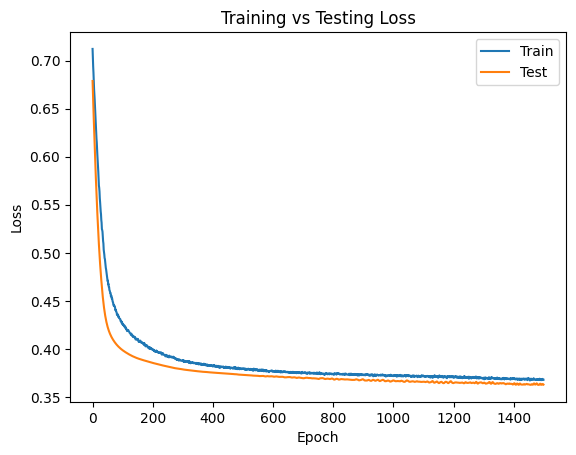

In [333]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Training vs Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

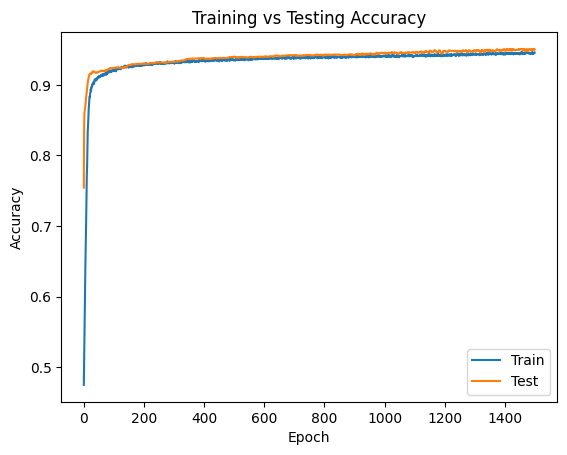

In [334]:
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [346]:
model

GCN_Enhanced(
  (conv1): GCNConv(6, 64)
  (norm1): LayerNorm(64, affine=True, mode=graph)
  (conv2): GCNConv(64, 32)
  (norm2): LayerNorm(32, affine=True, mode=graph)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv3): GCNConv(32, 16)
  (norm3): LayerNorm(16, affine=True, mode=graph)
  (conv4): GCNConv(16, 2)
)